## **<font color='#0e77c2' size='6px'>Imports</font>**

In [ ]:
from google.colab import drive
import os
import zipfile
import numpy as np
import random
import math
import time
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import matplotlib.pyplot as plt

## **<font color='#0e77c2' size='6px'>Problem Statement</font>**


In today’s era of data-driven decision-making, the ability to identify patterns, group similar entities, and extract insights from large datasets has become indispensable across various domains. Clustering a fundamental technique in unsupervised machine learning plays a key role in organizing data into meaningful groups based on similarities. The objective of this assignment is to help students understand how K-Means and Normalized Cut algorithms can be used
for the detection of daily and sports activities captured using motion sensors.


## **<font color='#0e77c2' size='6px'> Download Dataset and Understand the Format</font>**

We will use the ”Daily and Sports Activity” dataset for this assignment. The
dataset comprises motion sensor data of 19 daily and sports activities each
performed by 8 subjects in their style for 5 minutes. Five Xsens MTx units are
used on the torso, arms, and legs.

The dataset consists of 19 activities, each activity is done by 8 subjects for
5 minutes. The 5-minute signals are divided into 5-second segments so that
480(=60x8) signal segments are obtained for each activity. We will treat each
of these segments as a data point.

So our dataset now consists of 19 activities x 8 subjects x 60 segments resulting in 9120 data points. From each subject, we will take the first 48 segmentsfor training and the rest for evaluation.

Analyze the dataset and preprocess the dataset to be ready for clustering.

**This is to mount Google Drive because the dataset is there as a zip file**

In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


**This is to extract the Zip file of the dataset**

In [ ]:
# zip_file_path = "/content/drive/MyDrive/daily+and+sports+activities.zip"
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#      zip_ref.extractall('/content')

**This function reads a dataset from the given root directory, where the dataset is organized into folders representing different activities, subjects, and segments. It iterates over all combinations of activities, subjects, and segments, loads the data from each segment file, and assigns it to either the training or testing dataset based on the segment count. Finally, it returns the training and testing datasets along with their corresponding labels.**

In [ ]:
def read_dataset(root_dir):
    """
    Read the dataset from the given root directory.

    Parameters:
    - root_dir: str, the root directory containing the dataset.

    Returns:
    - dataset_training: numpy array of shape (n_samples_training, n_features), containing the training data.
    - dataset_testing: numpy array of shape (n_samples_testing, n_features), containing the testing data.
    - labels_training: numpy array of shape (n_samples_training,), containing the labels for the training data.
    - labels_testing: numpy array of shape (n_samples_testing,), containing the labels for the testing data.
    """

    # Define the list of activities, subjects, and segments
    activities = [f'a{i:02d}' for i in range(1, 20)]
    subjects = [f'p{i}' for i in range(1, 9)]
    segments = [f's{i:02d}.txt' for i in range(1, 61)]

    # Initialize lists to store training and testing data, and their corresponding labels
    dataset_training = []
    dataset_testing = []
    labels_training = []
    labels_testing = []

    # Iterate over activities, subjects, and segments to read the data files
    for activity_index, activity in enumerate(activities):
        for subject in subjects:
            segment_count = 0  # Counter to keep track of the number of segments
            for segment in segments:
                file_path = os.path.join(root_dir, activity, subject, segment)

                # Check if the file exists
                if os.path.exists(file_path):
                    try:
                        # Load data from the file
                        data = np.loadtxt(file_path, delimiter=',')

                        # Determine whether the segment belongs to training or testing data
                        if segment_count < 48:
                            dataset_training.append(data)
                            labels_training.append(activity_index + 1)
                        else:
                            dataset_testing.append(data)
                            labels_testing.append(activity_index + 1)

                        # Increment the segment count
                        segment_count += 1
                    except Exception as e:
                        print(f"Error reading file {file_path}: {e}")
                else:
                    print(f"Warning: File not found: {file_path}")

    # Convert lists to numpy arrays and return them
    return np.array(dataset_training), np.array(dataset_testing), np.array(labels_training), np.array(labels_testing)


**This function applies the first approach of taking the mean of each column of each segment resulting in 45 features for each data point**

In [ ]:
def mean_convert(dataset):
    return np.mean(dataset, axis=1)

**This function is used to apply the second approach of reducing the dataset using any dimensionality reduction technique, so we've used LDA, WHY?, because the dataset is labeled by the activity number, so, we've found it more convenient to reduce it using LDA not with PCA**

In [ ]:
def lda_convert(dataset_training, dataset_testing, y_train):
    """
    Apply Linear Discriminant Analysis (LDA) to the training and testing datasets.

    Parameters:
    - dataset_training: numpy array of shape (n_samples_training, n_features), containing the training data.
    - dataset_testing: numpy array of shape (n_samples_testing, n_features), containing the testing data.
    - y_train: numpy array of shape (n_samples_training,), containing the labels for the training data.

    Returns:
    - lda_X_train_projected: numpy array of shape (n_samples_training, n_components),
      containing the projected training data after LDA transformation.
    - lda_X_test_projected: numpy array of shape (n_samples_testing, n_components),
      containing the projected testing data after LDA transformation.
    """

    # Reshape the dataset into 2D array
    modified_dataset_training = np.reshape(dataset_training, (dataset_training.shape[0], -1))
    modified_dataset_testing = np.reshape(dataset_testing, (dataset_testing.shape[0], -1))

    # Initialize LDA model with number of components equal to number of classes - 1
    lda = LinearDiscriminantAnalysis(n_components=18)

    # Fit LDA model on training data and transform both training and testing data
    lda_X_train_projected = lda.fit_transform(modified_dataset_training, y_train)
    lda_X_test_projected = lda.transform(modified_dataset_testing)

    return lda_X_train_projected, lda_X_test_projected


## **<font color='#0e77c2' size='6px'> Clustering Using K-Means (Your implementation)</font>**

**This function implements the k-means clustering algorithm with a single run. It initializes centroids randomly, assigns data points to clusters based on the closest centroid, updates centroids iteratively, and checks for convergence based on the change in centroids or the maximum number of iterations. Finally, it calculates the Sum of Squared Errors (SSE) for the clusters and returns the clusters, centroids, and SSE.**

In [ ]:
def kMeans_single_run(data, k, epsilon):
    """
    Perform k-means clustering on the given data.

    Parameters:
    - data: numpy array of shape (n_samples, n_features) containing the data points.
    - k: int, number of clusters.
    - epsilon: float, threshold for convergence.

    Returns:
    - clusters: list of lists, indices of data points in each cluster.
    - centroids: numpy array, final centroids of the clusters.
    - SSE: Which is the sum of the square of errors
    """

    # Getting the number of data points
    n = data.shape[0]

    # Generate random indices to select k rows
    centroids_indices = np.random.choice(n, size=k, replace=False)

    # Select the random rows from the array to be the random initial centroids
    centroids = data[centroids_indices]

    # Defining the maximum number of iterations
    max_iterations = 1000

    # A boolean to tell us whether we've reached the epsilon or not
    converged = False

    # To help us know whether we've converged or not
    old_centroids = np.copy(centroids)

    clusters = []
    while (not converged) and (max_iterations > 0):
        clusters = []

        for _ in range(k):
            row = []
            clusters.append(row)

        # Assign points to clusters
        for point_index, point in enumerate(data):
            distances = np.linalg.norm(point - centroids, axis=1)
            closest_centroid_index = np.argmin(distances)
            clusters[closest_centroid_index].append(point_index)

        # Update centroids
        for i in range(k):
            if clusters[i]:
                centroids[i] = np.mean(data[clusters[i]], axis=0)

        # Checking stopping criteria
        diff = np.sum(np.linalg.norm(centroids - old_centroids, axis=1) ** 2)

        old_centroids = np.copy(centroids)

        # Check for convergence
        if diff <= epsilon:
            converged = True
        else:
            old_centroids = np.copy(centroids)
            max_iterations -= 1

    # Getting the SSE for this cluster
    SSE = 0.0
    for i in range(k):
        for j in range(len(clusters[i])):
            SSE += np.linalg.norm(data[j] - centroids[i])

    return clusters, centroids, SSE

**This function implements k-means clustering with multiple initial random starts. It runs the kMeans_single_run function multiple times, stores the clusters, centroids, and SSE for each run, and selects the run with the lowest SSE as the best run. Finally, it returns the clusters and centroids from the best run.**

In [ ]:
def kMeans(data, k, epsilon, initial_random_starts):
    """
    Perform k-means clustering on the given data with multiple initial random starts.

    Parameters:
    - data: numpy array of shape (n_samples, n_features) containing the data points.
    - k: int, number of clusters.
    - epsilon: float, threshold for convergence.
    - initial_random_starts: int, number of initial random starts.

    Returns:
    - clusters: list of lists, indices of data points in each cluster for the best run.
    - centroids: numpy array, final centroids of the clusters for the best run.
    """

    # Initialize lists to store clusters, centroids, and SSE for each run
    all_clusters = []
    all_centroids = []
    all_SSE = np.zeros(initial_random_starts, dtype=float)

    # Perform multiple initial random starts
    for i in range(initial_random_starts):
        # Run the k-means algorithm once
        clusters, centroids, SSE = kMeans_single_run(data, k, epsilon)

        # Store clusters, centroids, and SSE for this run
        all_clusters.append(clusters)
        all_centroids.append(centroids)
        all_SSE[i] = SSE

    # Find the index of the run with the lowest SSE
    best_run_index = np.argmin(all_SSE)

    # Return the clusters and centroids from the best run
    return all_clusters[best_run_index], all_centroids[best_run_index], all_SSE[best_run_index]

**This function takes test data and the centroids of clusters as input and assigns each test point to the cluster with the closest centroid. It returns a list of lists, where each sublist contains the indices of test data points assigned to a particular cluster.**

In [ ]:
def predict_clusters(test_data, centroids):
    """
    Predict clusters for the given test data based on the centroids of clusters.

    Parameters:
    - test_data: numpy array of shape (n_samples, n_features) containing the test data points.
    - centroids: numpy array, final centroids of the clusters.

    Returns:
    - predicted_clusters: list of lists, indices of test data points assigned to each cluster.
    """
    # Get the number of clusters
    k = centroids.shape[0]

    # Initialize an empty list to store predicted clusters
    predicted_clusters = []

    # Initialize an empty list for each cluster
    for _ in range(k):
        row = []
        predicted_clusters.append(row)

    # Assign each test point to the cluster with the closest centroid
    for test_point_index, test_point in enumerate(test_data):
        # Calculate distances between the test point and centroids
        distances = np.linalg.norm(test_point - centroids, axis=1)

        # Find the index of the closest centroid
        closest_centroid_index = np.argmin(distances)

        # Append the index of the test point to the corresponding cluster
        predicted_clusters[closest_centroid_index].append(test_point_index)

    return predicted_clusters


In [ ]:
def test_kMeans():
    # Define the root directory containing the dataset
    root_directory = "/content/data"

    # Read the dataset
    dataset_traing, dataset_testing, labels_training, labels_testing = read_dataset(root_directory)

    # Convert dataset using mean approach
    data_mean_convert = mean_convert(dataset_traing)

    # Convert dataset using LDA reduction
    training_data_lda_convert, testing_data_lda_convert = lda_convert(dataset_traing, dataset_testing, labels_training)

    # Define the values of k to test
    k_s = [8, 13, 19, 28, 38]

    # Define epsilon and initial_random_starts for kMeans
    epsilon = 1e-4
    initial_random_starts = 10

    # Perform kMeans using the mean approach
    print("Kmeans Using the Mean approach: ")
    sse_values_mean = []  # Store SSE values for each k
    for k in k_s:
        print('k = ', k)
        print()
        clusters, centroids, sse = kMeans(data=data_mean_convert, epsilon=epsilon, k=k, initial_random_starts=initial_random_starts)
        sse_values_mean.append(sse)
        print(clusters)
        print()
        print()

    # Plot SSE vs. k for the mean approach
    plt.plot(k_s, sse_values_mean, marker='o')
    plt.title('Elbow Method for Optimal k of the column mean approach')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.xticks(k_s)
    plt.grid(True)
    plt.show()

    # Perform kMeans using the LDA reduction approach
    print("Kmeans Using the lda-reduction approach: ")
    sse_values_lda = []  # Store SSE values for each k
    for k in k_s:
        print('k = ', k)
        print()
        clusters, centroids, sse = kMeans(data=training_data_lda_convert, epsilon=epsilon, k=k, initial_random_starts=initial_random_starts)
        sse_values_lda.append(sse)
        print(clusters)
        print()
        print()

    # Plot SSE vs. k for the LDA reduction approach
    plt.plot(k_s, sse_values_lda, marker='o')
    plt.title('Elbow Method for Optimal k of the lda-reduction approach')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.xticks(k_s)
    plt.grid(True)
    plt.show()

Kmeans Using the Mean approach: 
k =  8

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

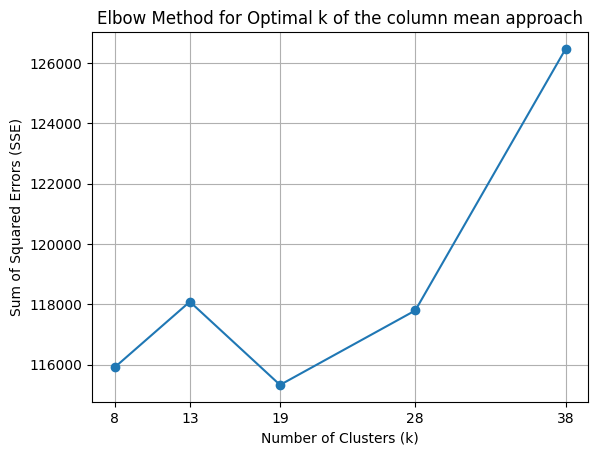

Kmeans Using the lda-reduction approach: 
k =  8

[[768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957

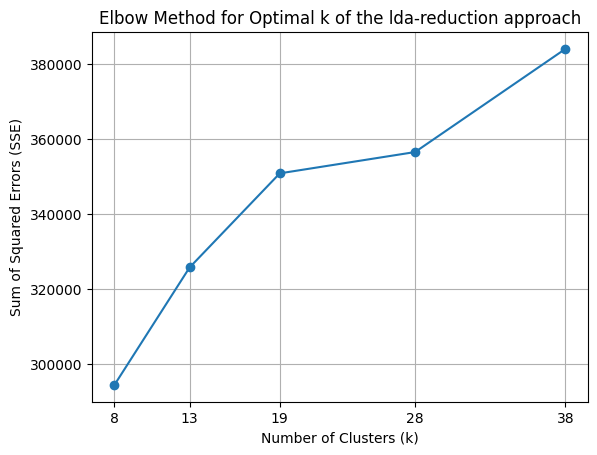

In [ ]:
# Call the test_kMeans function to run the test
test_kMeans()

## **<font color='#0e77c2' size='6px'>Normalized Cut (Your implementation)</font>**

Here, we will use the Normalized cut algorithm to cluster the daily and sports
activities. For this experiment.

• Apply Normalized Cut algorithm to the two solutions to cluster the data
into 19 clusters.

• Compare the results of K-Means and Normalized Cut clustering regarding
the number of detected activities and their characteristics

## **Normalized Cut Clustering Implementation**

This function implements the normalized cut algorithm for spectral clustering. Here's a breakdown of the steps:

1. **Compute Laplacian Matrix (La)**: Calculates the Laplacian matrix using the input adjacency matrix.
2. **Compute Eigenvalues and Eigenvectors**: Uses numpy's linear algebra module to compute the eigenvalues and eigenvectors of the Laplacian matrix.
3. **Sort Eigenvalues and Eigenvectors**: Sorts the eigenvalues and corresponding eigenvectors in ascending order.
4. **Extract Top k Eigenvectors**: Selects the top k eigenvectors to form the matrix Y.
5. **Perform k-Means Clustering**: Applies k-means clustering algorithm on the matrix Y to partition the data into k clusters.
6. **Return Cluster Labels**: Returns the labels assigned by k-means, indicating the cluster to which each data point belongs.

In [ ]:
def normalized_cut(A, k):
    """
    Perform spectral clustering using the Normalized Cut algorithm.

    Parameters:
    -----------
    A : array_like
        Adjacency matrix representing the graph.

    k : int
        Number of clusters to form.

    Returns:
    --------
    labels : array_like
        Labels of each point indicating the cluster to which it belongs.
    """

    # Step 1: Compute the Laplacian matrix, La
    row_sums = np.sum(A, axis=1)
    degree_inv = np.diag(1 / row_sums)
    La = np.identity(A.shape[0]) - np.dot(degree_inv, A)

    # Step 2: Compute eigenvalues and eigenvectors of La
    eigen_values, eigen_vectors = np.linalg.eig(La)

    # Step 3: Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigen_values)
    eigen_values_sorted = eigen_values[sorted_indices]
    eigen_vectors_sorted = eigen_vectors[:, sorted_indices]

    # Step 4: Extract top k eigenvectors to form matrix Y
    U = eigen_vectors_sorted[:, : k]
    norms = np.linalg.norm(U, axis=1, keepdims=True)
    norms[norms == 0] = 1
    Y = U / norms

    # Step 5: Perform k-means clustering on Y
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y.real)

    # Return the labels assigned by k-means
    return kmeans.labels_

## **Compute Similarity Matrix via KNN**

This function calculates the similarity matrix for a given dataset using the K-nearest neighbors (KNN) graph approach. Here's a breakdown of the steps:

1. **Compute K-nearest Neighbors Graph**: Constructs the KNN graph using the input dataset and the specified number of nearest neighbors (k).
2. **Convert KNN Graph to Similarity Matrix**: Converts the binary KNN graph to a similarity matrix, where each entry represents the similarity between corresponding samples.
3. **Convert Binary Similarity Matrix to Similarity Scores**: Converts the binary (0 or 1) similarity matrix to similarity scores by averaging the values with their transposed counterparts to ensure symmetry.
4. **Return Similarity Matrix**: Returns the symmetric similarity matrix representing pairwise similarities between samples in the dataset.

In [ ]:
from sklearn.neighbors import kneighbors_graph

def compute_similarity_matrix(data, k):
    """
    Compute the similarity matrix for a given dataset using the K-nearest neighbors (KNN) graph.

    Parameters:
    -----------
    data : array_like
        Input dataset of size n*d, where n is the number of samples and d is the number of features.

    k : int
        Number of nearest neighbors to consider for constructing the KNN graph.

    Returns:
    --------
    similarity_matrix : array_like
        Symmetric similarity matrix of size n*n, where similarity_matrix[i][j] represents the similarity between sample i and j.
    """

    # Step 1: Compute K-nearest neighbors graph
    knn_graph = kneighbors_graph(data, n_neighbors=k, mode='connectivity', include_self=True)

    # Step 2: Convert K-nearest neighbors graph to similarity matrix
    similarity_matrix = np.array(knn_graph.toarray())

    # Step 3: Convert binary (0 or 1) similarity matrix to similarity scores
    similarity_matrix = 0.5 * (similarity_matrix + similarity_matrix.T)

    return similarity_matrix

## **get cluster utility function:**

This function extracts clusters from the labels assigned by a clustering algorithm. Here's a breakdown of the steps:

1. **Initialize Empty List**: Initializes an empty list to store clusters.
2. **Find Unique Labels**: Finds the unique labels present in the clustering labels array.
3. **Extract Cluster Indices**: Iterates over unique labels and finds the indices corresponding to each cluster label. These indices represent the data points assigned to that cluster.
4. **Return List of Clusters**: Returns the list of clusters, where each cluster is represented as a list of indices belonging to that cluster.

This utility function is useful for analyzing and visualizing the clusters obtained from a clustering algorithm. It provides a convenient way to access the data points belonging to each cluster for further analysis or visualization.

In [ ]:
def get_clusters(clustering_labels):
    """
    Extract clusters from clustering labels.

    Parameters:
    -----------
    clustering_labels : array_like
        Labels assigned by a clustering algorithm indicating the cluster to which each data point belongs.

    Returns:
    --------
    clusters : list
        List of clusters, where each cluster is represented as a list of indices belonging to that cluster.
    """

    # Step 1: Initialize an empty list to store clusters
    clusters = []

    # Step 2: Find unique labels in the clustering labels
    unique_labels = np.unique(clustering_labels)

    # Step 3: Iterate over unique labels and extract indices for each cluster
    for label in unique_labels:
        cluster_indices = np.where(clustering_labels == label)[0]
        clusters.append(cluster_indices.tolist())

    # Step 4: Return the list of clusters
    return clusters

## **Test normalized cut spectral clustering**

This function tests the performance of the Normalized Cut algorithm on different data preprocessing methods and evaluates it on both training and testing sets. It measures the clustering time and quality metrics for each approach. Here's a breakdown of the steps:

1. **Read Dataset and Labels**: Reads the dataset and corresponding labels from the specified directory.
2. **Preprocess Datasets**: Preprocesses the datasets using two different methods: mean conversion followed by cosine similarity computation, and Linear Discriminant Analysis (LDA) followed by KNN graph construction.
3. **Evaluate Normalized Cut Algorithm**: Evaluates the Normalized Cut algorithm on both preprocessing solutions for both training and testing sets. It measures clustering time and clustering quality metrics for each case.

This function is useful for comparing the performance of the Normalized Cut algorithm under different preprocessing techniques and understanding its effectiveness in clustering datasets.

In [ ]:
def test_normalized_cut():
    """
    Test the performance of the Normalized Cut algorithm on different data preprocessing methods.

    This function evaluates the Normalized Cut algorithm on both training and testing sets using two different data preprocessing methods:
    1. Mean conversion followed by cosine similarity computation.
    2. Linear Discriminant Analysis (LDA) followed by KNN graph construction to compute similarity matrix.

    The function prints the evaluation results including clustering time and clustering quality metrics for both training and testing sets.
    """

    root_directory = "/content/data"
    dataset_training, dataset_testing, labels_training, labels_testing = read_dataset(root_directory)

    dataset_training1 = mean_convert(dataset_training)
    dataset_testing1 = mean_convert(dataset_testing)

    # Solution 1: Mean convert
    # Evaluate training set
    start = time.time()
    clustering_labels_train_mean = normalized_cut(cosine_similarity(dataset_training1), k=19)
    end = time.time()
    time_train_mean = (end - start) / 60
    precision_train_mean, recall_train_mean, f_measure_train_mean, entropy_train_mean = evaluate_cluster(get_clusters(clustering_labels_train_mean), labels_training)

    # Evaluate testing set
    start = time.time()
    clustering_labels_test_mean = normalized_cut(cosine_similarity(dataset_testing1), k=19)
    end = time.time()
    time_test_mean = (end - start) / 60
    clusters_test_mean = get_clusters(clustering_labels_test_mean)
    precision_test_mean, recall_test_mean, f_measure_test_mean, entropy_test_mean = evaluate_cluster(clusters_test_mean, labels_testing)

    # Solution 2: Linear Discriminant Analysis (LDA) conversion
    dataset_training2, dataset_testing2 = lda_convert(dataset_training, dataset_testing, labels_training)

    # Evaluate training set
    start = time.time()
    clustering_labels_train_dim = normalized_cut(compute_similarity_matrix(dataset_training2, 19), k=19)
    end = time.time()
    time_train_dim = (end - start) / 60
    precision_train_dim, recall_train_dim, f_measure_train_dim, entropy_train_dim = evaluate_cluster(get_clusters(clustering_labels_train_dim), labels_training)

    # Evaluate testing set
    start = time.time()
    clustering_labels_test_dim = normalized_cut(compute_similarity_matrix(dataset_testing2, 19), k=19)
    end = time.time()
    time_test_dim = (end - start) / 60
    clusters_test_dim = get_clusters(clustering_labels_test_dim)
    precision_test_dim, recall_test_dim, f_measure_test_dim, entropy_test_dim = evaluate_cluster(clusters_test_dim, labels_testing)

    # Store the results
    results = {
        "Train Mean Convert": [time_train_mean, precision_train_mean, recall_train_mean, f_measure_train_mean, entropy_train_mean],
        "Test Mean Convert": [time_test_mean, precision_test_mean, recall_test_mean, f_measure_test_mean, entropy_test_mean],
        "Train Dim Reduction": [time_train_dim, precision_train_dim, recall_train_dim, f_measure_train_dim, entropy_train_dim],
        "Test Dim Reduction": [time_test_dim, precision_test_dim, recall_test_dim, f_measure_test_dim, entropy_test_dim]
    }

    return results, clusters_test_mean, clusters_test_dim

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Precision is:  0.5211074561403508
The Recall is:  0.4556779923045211
The F1-Measure is:  0.510450196441285
The Entropy is:  1.7200191416402604
The Jaccard Index is:  0.2453921473402804
The Rand Index is:  0.9264314508856102


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Precision is:  0.5290570175438596
The Recall is:  0.41865189289012006
The F1-Measure is:  0.5215022808012056
The Entropy is:  1.7230929047329624
The Jaccard Index is:  0.24943438525069284
The Rand Index is:  0.9343518732376745


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Precision is:  0.9978070175438594
The Recall is:  0.9957543172552792
The F1-Measure is:  0.9978040069847784
The Entropy is:  0.014728497476458921
The Jaccard Index is:  0.9914039257044925
The Rand Index is:  0.9995467109772375


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Precision is:  0.45833333333333326
The Recall is:  0.3280932594644506
The F1-Measure is:  0.4647988002349792
The Entropy is:  2.38262847261224
The Jaccard Index is:  0.18770222263308725
The Rand Index is:  0.9260087959888751
Results:
                       Train Mean Convert  Test Mean Convert  \
Clustering Time (min)            5.768073           0.112901   
Precision                        0.521107           0.529057   
Recall                           0.455678           0.418652   
F1-Measure                       0.510450           0.521502   
Entropy                          1.720019           1.723093   

                       Train Dim Reduction  Test Dim Reduction  
Clustering Time (min)             5.600399            0.157023  
Precision                         0.997807            0.458333  
Recall                            0.995754            0.328093  
F1-Measure                        0.997804            0.464799  
Entropy                           0.014728          

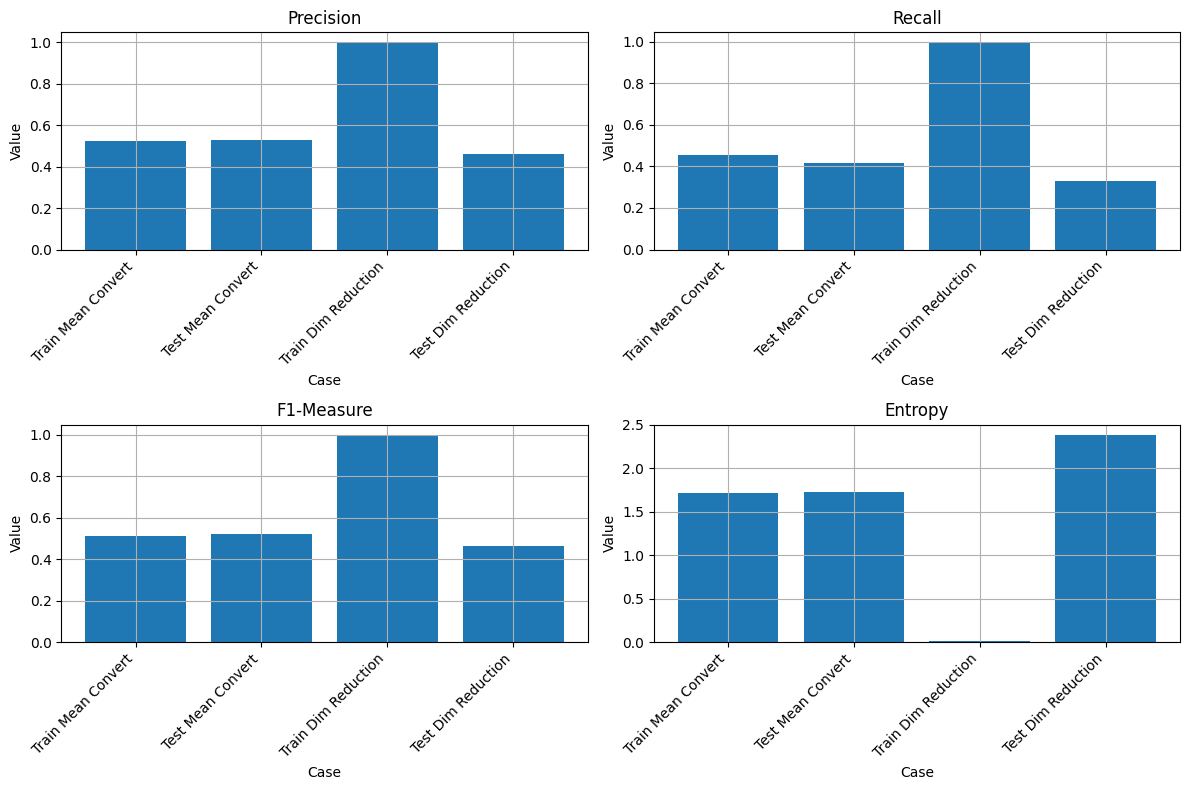

In [ ]:
results, clusters_test_mean, clusters_test_dim = test_normalized_cut()

# Create a DataFrame from the results
results_df = pd.DataFrame(results, index=["Clustering Time (min)", "Precision", "Recall", "F1-Measure", "Entropy"])


# Display the results in a tabulated format
print("Results:")
print(results_df)
print("-----------------------------------------------------------------")

# Display the clusters for the test mean convert solution
print("Clusters for Test Mean Convert:")
print("Cluster\tNumber of Points")
for i, cluster in enumerate(clusters_test_mean):
    print(f"{i + 1}\t{len(cluster)}")

print("-----------------------------------------------------------------")

# Display the clusters for the test dim reduction solution
print("Clusters for Test Dim Reduction:")
print("Cluster\tNumber of Points")
for i, cluster in enumerate(clusters_test_dim):
    print(f"{i + 1}\t{len(cluster)}")

print("-----------------------------------------------------------------")

# Plotting the results
measures = ["Precision", "Recall", "F1-Measure", "Entropy"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, measure in enumerate(measures):
    ax = axes[i // 2, i % 2]
    bars = ax.bar(results.keys(), results_df.loc[measure])
    ax.set_title(measure)
    ax.set_ylabel("Value")
    ax.set_xlabel("Case")
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## **<font color='#0e77c2' size='6px'>Evaluation Measures</font>**
We will evaluate models based on their ability to detect daily and sports activities accurately. You will be required to use the following metrics to evaluate
the quality of their models:

• Precision

• Recall

• F1 score

• Conditional Entropy

Below is a brief description of functions used to calculate clustering measures:

1. **get_dominant_class(cluster_labels)**:
   - Finds the dominant class label within a cluster along with the number of points assigned to that dominant class.
   
2. **get_preci(cluster, cluster_labels)**:
   - Computes the precision (purity) of a cluster, which is the ratio of the number of points assigned to the dominant class to the total number of points in the cluster.
   
3. **get_reci(cluster, labels)**:
   - Calculates the recall of a cluster, which is the ratio of the number of points assigned to the dominant class to the total number of points belonging to that class in the entire dataset.
   
4. **get_Fi(cluster, labels)**:
   - Computes the F1-measure of a cluster, which is the harmonic mean of precision and recall.
   
5. **get_F_measure(clusters, labels)**:
   - Calculates the F1-measure of the entire clustering result by averaging the F1-measure of all clusters.
   
6. **get_purity(clusters, labels)**:
   - Computes the purity measure of the clustering result, which is a weighted average of cluster purity values.
   
7. **get_cluster_classes_count(cluster, labels, n_classes)**:
   - Counts the occurrences of each class label within a cluster.
   
8. **get_TP(clusters, labels, n_classes)**:
   - Calculates the total number of true positive pairs across all clusters.
   
9. **get_FP(clusters, labels, n_classes)**:
   - Computes the total number of false positive pairs across all clusters.
   
10. **get_FN(clusters, labels, n_classes)**:
    - Calculates the total number of false negative pairs across all clusters.
   
11. **get_TN(clusters, labels, n_classes)**:
    - Computes the total number of true negative pairs across all clusters.
   
12. **get_recall(clusters, labels, n_classes)**:
    - Computes the recall measure of the entire clustering result.
   
13. **get_pairwise(clusters, labels, n_classes)**:
    - Calculates pairwise clustering similarity measures: Jaccard similarity coefficient and Rand index.
   
14. **get_class_count(cluster, labels, label)**:
    - Counts the occurrences of a specified class label within a cluster.
   
15. **get_Entropy(clusters, labels, n_classes)**:
    - Calculates the conditional entropy of clusters given class labels.

These functions provide various metrics to evaluate the quality and performance of clustering algorithms. They are useful for assessing the purity, completeness, and pairwise agreement of clustering results against ground truth labels.

In [ ]:
def get_dominant_class(cluster_labels):
    """
       Parameters:
       - cluster_labels: the labels of each point in the given cluster
       Returns:
       - max_nij: number of points in ci labeled as the dominant class in the given cluster.
       - dominant_class: the label of the dominant class itself
    """
    unique_labels, labels_count = np.unique(cluster_labels, return_counts=True)
    dominant_label_index = np.argmax(labels_count)
    max_nij = labels_count[dominant_label_index]
    dominant_class = unique_labels[dominant_label_index]
    return max_nij, dominant_class


def get_preci(cluster, cluster_labels):
    """
       Parameters:
       - cluster: array represents the indices of the points of this cluster in the original dataset.
       - cluster_labels: the labels of each point in the given cluster
       Returns:
       - preci: the precision of the given cluster.
    """
    max_nij, dominant_class = get_dominant_class(cluster_labels)
    return max_nij / len(cluster)


def get_reci(cluster, labels):
    """
       Parameters:
       - cluster: array represents the indices of the points of this cluster in the original dataset.
       - labels: labels of all points in the dataset
       Returns:
       - reci: the recall of the given cluster.
    """
    cluster_labels = labels[cluster]
    max_nij, dominant_class = get_dominant_class(cluster_labels)
    # Count the occurrences of the dominant class label in the entire dataset
    mj = np.sum(labels == dominant_class)
    return max_nij / mj


def get_Fi(cluster, labels):
    """
       Parameters:
       - cluster: array represents the indices of the points of this cluster in the original dataset.
       - labels: labels of all points in the dataset
       Returns:
       - Fi: the Fi measure of the given cluster.
    """
    # Get the labels of points in the given cluster
    cluster_labels = labels[cluster]
    preci = get_preci(cluster, cluster_labels)
    reci = get_reci(cluster, labels)
    return (2 * preci * reci) / (preci + reci)


def get_F_measure(clusters, labels):
    """
       Parameters:
       - clusters: array of clusters where each element is an array representing a cluster
       - labels: labels of all points in the dataset
       Returns:
       - F: the F measure of the given clusters.
    """
    F = 0
    for cluster in clusters:
        F += get_Fi(cluster, labels)
    return F / len(clusters)

# precision or purity measure
def get_purity(clusters, labels):
    """
       Parameters:
       - clusters: array of clusters where each element is an array representing a cluster
       - labels: labels of all points in the dataset
       Returns:
       - purity: the purity measure of the given clusters.
    """
    purity = 0
    n = len(labels)
    for cluster in clusters:
        purity += (len(cluster)/n * get_preci(cluster, labels[cluster]))
    return purity

In [ ]:
def get_cluster_classes_count(cluster, labels, n_classes):
    """
    Parameters:
    - cluster: array represents the indices of the points of this cluster in the original dataset.
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - class_counts: array where each element represents the number of points in the given cluster belonging to the corresponding class.
    """
    class_counts = np.zeros(n_classes)

    # Get the labels of points in the given cluster
    cluster_labels = labels[cluster]

    # Count the occurrences of each class label in the cluster
    for i in range(n_classes):
        class_counts[i] = np.sum(cluster_labels == i + 1)  # Labels start from 1

    return class_counts


def get_TP(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - TP: True Positives, representing the total number of true positive pairs across all clusters.
    """
    TP = 0
    for cluster in clusters:
        classes_count = get_cluster_classes_count(cluster, labels, n_classes)
        for c in classes_count:
            TP += c * (c - 1) / 2
    return TP


def get_FP(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - FP: False Positives, representing the total number of false positive pairs across all clusters.
    """
    FP = 0
    for cluster in clusters:
        classes_count = get_cluster_classes_count(cluster, labels, n_classes)
        for c1 in range(n_classes - 1):
            for c2 in range(c1 + 1, n_classes):
                FP += classes_count[c1] * classes_count[c2]
    return FP


def get_FN(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - FN: False Negatives, representing the total number of false negative pairs across all clusters.
    """
    FN = 0
    r = len(clusters)
    for cl1 in range(r - 1):
        for cl2 in range(cl1 + 1, r):
            class_count1 = get_cluster_classes_count(clusters[cl1], labels, n_classes)
            class_count2 = get_cluster_classes_count(clusters[cl2], labels, n_classes)
            for j in range(n_classes):
                FN += class_count1[j] * class_count2[j]
    return FN


def get_TN(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - TN: True Negatives, representing the total number of true negative pairs across all clusters.
    """
    TN = 0
    r = len(clusters)
    for cl1 in range(r - 1):
        for cl2 in range(cl1 + 1, r):
            class_count1 = get_cluster_classes_count(clusters[cl1], labels, n_classes)
            class_count2 = get_cluster_classes_count(clusters[cl2], labels, n_classes)
            for j1 in range(n_classes):
                for j2 in range(n_classes):
                    if j1 != j2:
                        TN += class_count1[j1] * class_count2[j2]
    return TN


def get_recall(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - recall: the recall measure of the entire clusters.
    """
    TP = get_TP(clusters, labels, n_classes)
    FN = get_FN(clusters, labels, n_classes)
    return TP / (TP + FN)


# pairwise measure
def get_pairwise(clusters, labels, n_classes):
    """
    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes
    Returns:
    - jaccard: Jaccard similarity coefficient
    - rand: Rand index
    """
    TP = get_TP(clusters, labels, n_classes)
    TN = get_TN(clusters, labels, n_classes)
    FP = get_FP(clusters, labels, n_classes)
    FN = get_FN(clusters, labels, n_classes)

    jaccard = TP / (TP + FP + FN)
    rand = (TP + TN) / (TP + TN + FP + FN)
    return jaccard, rand


def get_class_count(cluster, labels, label):
    """
    Parameters:
    - cluster: array represents the indices of the points of this cluster in the original dataset.
    - labels: labels of all points in the dataset
    - label: the label to match
    Returns:
    - count: the number of points in the given cluster that belong to the specified label.
    """
    # Get the labels of points in the given cluster
    cluster_labels = labels[cluster]

    # Count the occurrences of the specified label in the cluster
    count = np.sum(cluster_labels == label)

    return count


def get_Entropy(clusters, labels, n_classes):
    """
    Calculate the conditional entropy of clusters given class labels.

    Parameters:
    - clusters: array of clusters where each element is an array representing a cluster
    - labels: labels of all points in the dataset
    - n_classes: number of unique classes

    Returns:
    - H_T_C: the conditional entropy of the clusters given the class labels.
    """
    r = len(clusters)
    H_T_Ci = np.zeros(r)
    for i in range(r):
        for j in range(n_classes):
            temp = get_class_count(clusters[i], labels, j + 1) / len(clusters[i])
            if temp != 0:
                H_T_Ci[i] -= (temp * math.log2(temp))

    H_T_C = 0
    n = len(labels)
    for i in range(r):
        H_T_C += len(clusters[i]) / n * H_T_Ci[i]
    return H_T_C

In [ ]:
def evaluate_cluster(cluster, labels):
    """
    Evaluate the clustering performance using various clustering quality metrics.

    This function computes and prints several clustering quality metrics including Precision, Recall, F1-Measure,
    Entropy, Jaccard Index, and Rand Index.

    Parameters:
    -----------
    cluster : list
        List of clusters, where each cluster is represented as a list of indices belonging to that cluster.

    labels : array_like
        True labels indicating the ground truth cluster assignment of each data point.
    """

    # Step 1: Compute clustering quality metrics
    f_measure = get_F_measure(cluster, labels)
    precision = get_purity(cluster, labels)
    recall = get_recall(clusters=cluster, labels=labels, n_classes=19)
    jaccard, rand = get_pairwise(clusters=cluster, labels=labels, n_classes=19)
    entropy = get_Entropy(clusters=cluster, labels=labels, n_classes=19)

    # Step 2: Print clustering quality metrics
    print("The Precision is: ", precision)
    print("The Recall is: ", recall)
    print("The F1-Measure is: ", f_measure)
    print("The Entropy is: ", entropy)
    print("The Jaccard Index is: ", jaccard)
    print("The Rand Index is: ", rand)

    return precision, recall, f_measure, entropy

## **Kmeans evaluation results and compares**

In [ ]:
def evaluate_kMeans(k):
  # Read data sets
  root_directory = "/content/data"
  dataset_traing, dataset_testing, labels_training, labels_testing = read_dataset(root_directory)

  dataset_traing1 = mean_convert(dataset_traing)
  dataset_testing1 = mean_convert(dataset_testing)

  dataset_traing2, dataset_testing2 = lda_convert(dataset_traing, dataset_testing, labels_training)

  epsilon= 1e-5
  initial_random_starts=20

  print("--------------------------K-Means evaluation using the mean of each column approach-------------------------------")
  print()
  clusters1, centroids1, sse = kMeans(data=dataset_traing1, epsilon=epsilon ,k=k, initial_random_starts=initial_random_starts)
  print()
  print("------------Training data evaluation----------")
  clusters1 = [sublist for sublist in clusters1 if sublist]
  precision_train_mean, recall_train_mean, f_measure_train_mean, entropy_train_mean = evaluate_cluster(clusters1, labels_training )
  print()
  print()
  print("------------Testing data evaluation----------")
  predicted_clusters1 = predict_clusters(test_data=dataset_testing1,centroids= centroids1)
  predicted_clusters1 = [sublist for sublist in predicted_clusters1 if sublist]
  precision_test_mean, recall_test_mean, f_measure_test_mean, entropy_test_mean = evaluate_cluster(predicted_clusters1, labels_testing )
  print()
  print()

  print("--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------")
  print()
  clusters2, centroids2, sse = kMeans(data=dataset_traing2, epsilon=epsilon ,k=k, initial_random_starts=initial_random_starts)
  print()
  print("------------Training data evaluation----------")
  clusters2 = [sublist for sublist in clusters2 if sublist]
  precision_train_dim, recall_train_dim, f_measure_train_dim, entropy_train_dim = evaluate_cluster(clusters2, labels_training )
  print()
  print()
  print("------------Testing data evaluation----------")
  predicted_clusters2 = predict_clusters(test_data=dataset_testing2,centroids= centroids2)
  predicted_clusters2 = [sublist for sublist in predicted_clusters2 if sublist]
  precision_test_dim, recall_test_dim, f_measure_test_dim, entropy_test_dim = evaluate_cluster(predicted_clusters2, labels_testing )
  print()
  print()

  # Store the results

  results = {
      "Train Mean Convert": [precision_train_mean, recall_train_mean, f_measure_train_mean, entropy_train_mean],
      "Test Mean Convert": [precision_test_mean, recall_test_mean, f_measure_test_mean, entropy_test_mean],
      "Train Dim Reduction": [precision_train_dim, recall_train_dim, f_measure_train_dim, entropy_train_dim],
      "Test Dim Reduction": [precision_test_dim, recall_test_dim, f_measure_test_dim, entropy_test_dim]
  }
  return results, predicted_clusters1, predicted_clusters2

--------------------------K-Means evaluation using the mean of each column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.328125
The Recall is:  0.6818887132976044
The F1-Measure is:  0.5588471683540754
The Entropy is:  2.432008666835668
The Jaccard Index is:  0.1500631377069853
The Rand Index is:  0.7972319045128242


------------Testing data evaluation----------
The Precision is:  0.3294956140350877
The Recall is:  0.6912280701754386
The F1-Measure is:  0.568146678747352
The Entropy is:  2.4357135186366023
The Jaccard Index is:  0.14336704769884492
The Rand Index is:  0.7847695383549383


--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.42105263157894735
The Recall is:  1.0
The F1-Measure is:  0.8143939393939393
The Entropy is:  1.9589095236249274
The Jaccard Index is:  0.167777188573536

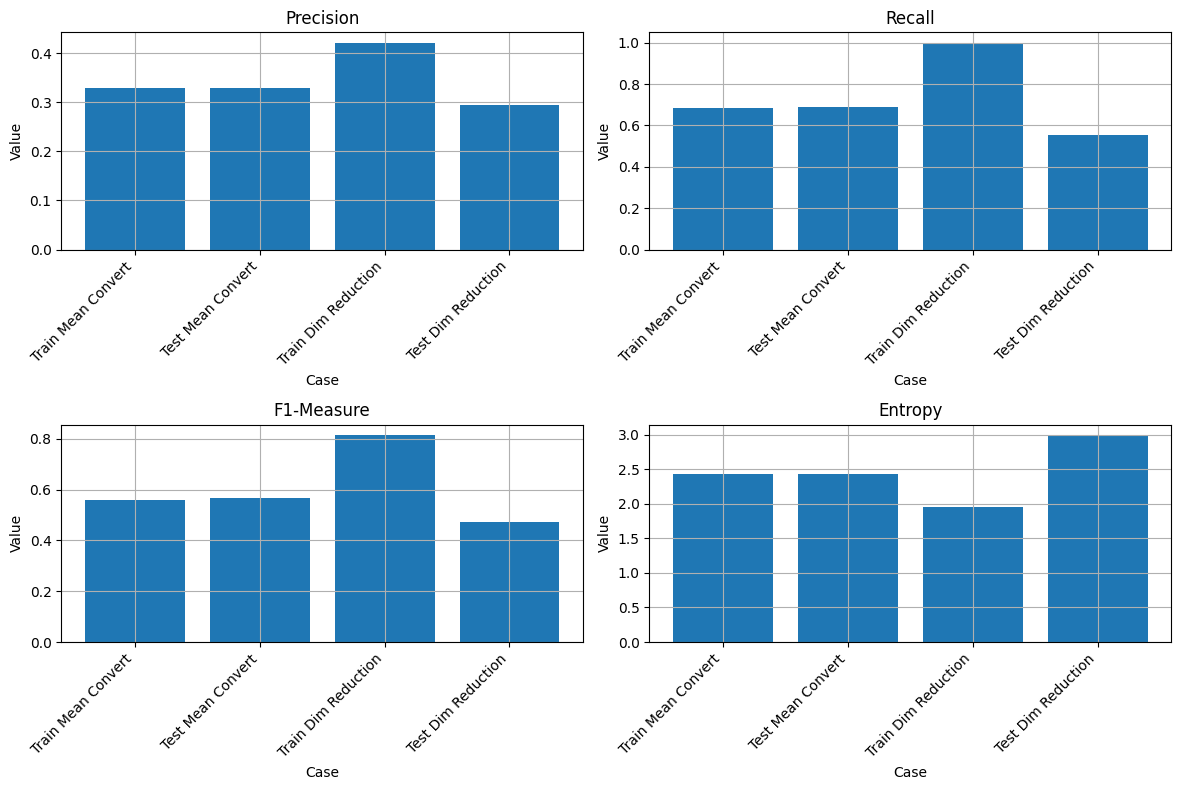

--------------------------K-Means evaluation using the mean of each column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.4416118421052631
The Recall is:  0.4998081856076222
The F1-Measure is:  0.5525858534015574
The Entropy is:  2.065000970336526
The Jaccard Index is:  0.21772249457816975
The Rand Index is:  0.9057167851087623


------------Testing data evaluation----------
The Precision is:  0.44024122807017546
The Recall is:  0.4970567867036011
The F1-Measure is:  0.5527910311875451
The Entropy is:  2.0342500100299468
The Jaccard Index is:  0.21506691969636435
The Rand Index is:  0.9054629683094186


--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.631578947368421
The Recall is:  0.9789090055425771
The F1-Measure is:  0.8842118798096356
The Entropy is:  1.263157894736842
The Jaccard Ind

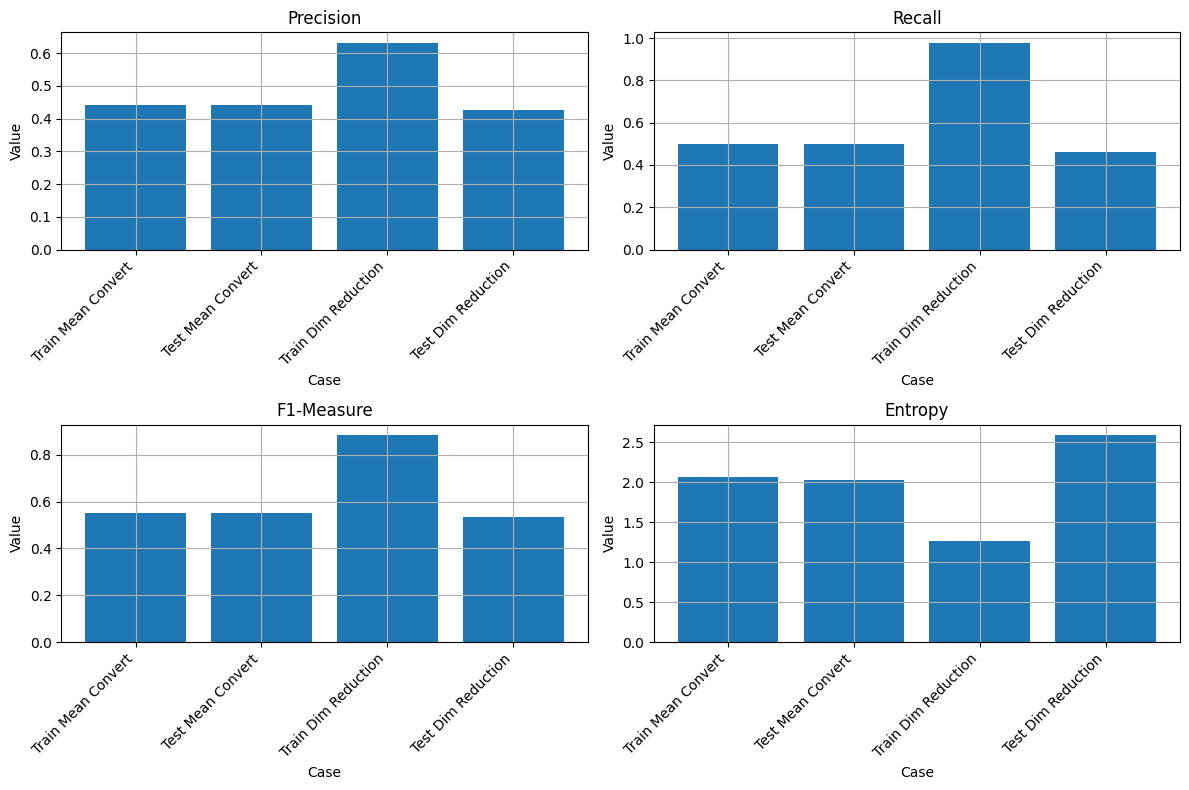

--------------------------K-Means evaluation using the mean of each column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.46696820175438586
The Recall is:  0.4179814541248683
The F1-Measure is:  0.47423713563184344
The Entropy is:  1.9054441915891795
The Jaccard Index is:  0.21220073275033546
The Rand Index is:  0.9185297247574041


------------Testing data evaluation----------
The Precision is:  0.4709429824561403
The Recall is:  0.42240304709141274
The F1-Measure is:  0.47552839602181385
The Entropy is:  1.880447979701567
The Jaccard Index is:  0.21014280546416084
The Rand Index is:  0.9172633311199007


--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.7368421052631577
The Recall is:  0.9257499370161697
The F1-Measure is:  0.8202505475781385
The Entropy is:  0.7162968670756216
The Jaccar

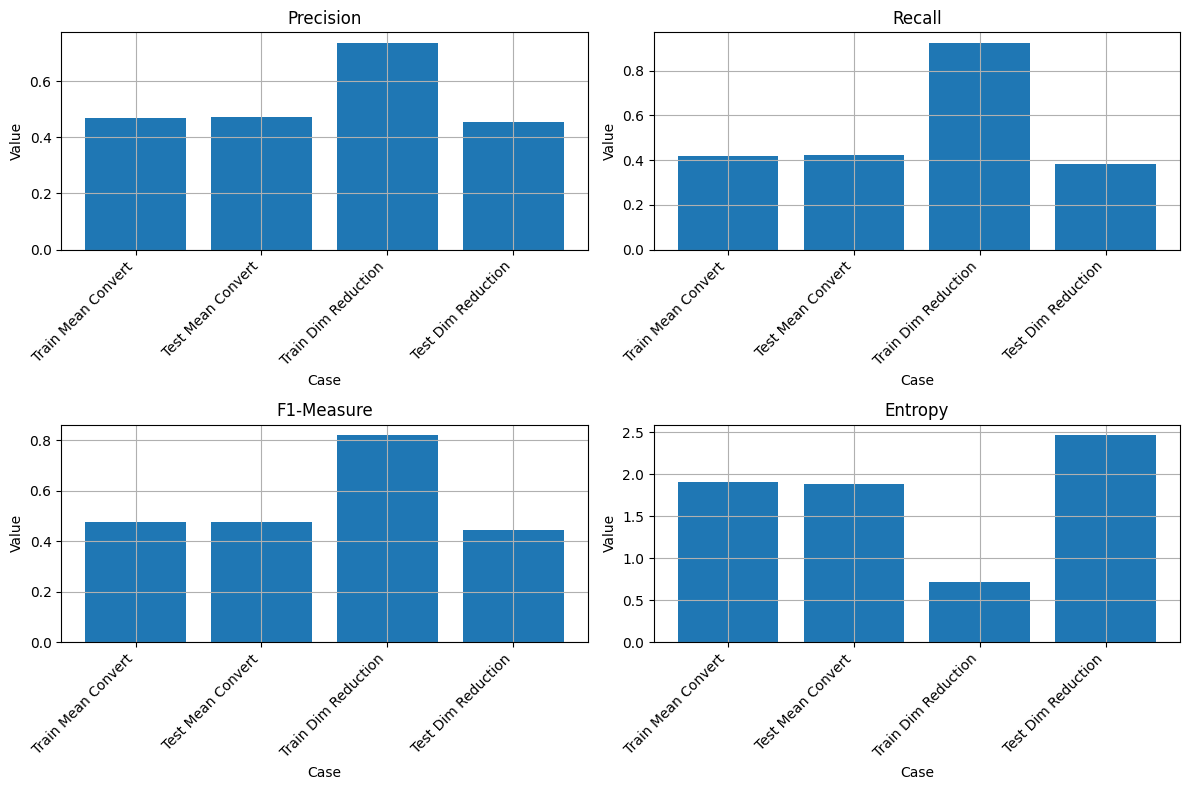

--------------------------K-Means evaluation using the mean of each column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.49739583333333337
The Recall is:  0.32416346021712245
The F1-Measure is:  0.3914672736749137
The Entropy is:  1.8511333070570763
The Jaccard Index is:  0.18101087545580838
The Rand Index is:  0.9229964046511069


------------Testing data evaluation----------
The Precision is:  0.4989035087719298
The Recall is:  0.3203947368421053
The F1-Measure is:  0.3949997957949412
The Entropy is:  1.8139632016542813
The Jaccard Index is:  0.17739533873121976
The Rand Index is:  0.9225767724302528


--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.8926809210526315
The Recall is:  0.7996870848793001
The F1-Measure is:  0.6767599430549865
The Entropy is:  0.2264206050658975
The Jaccard

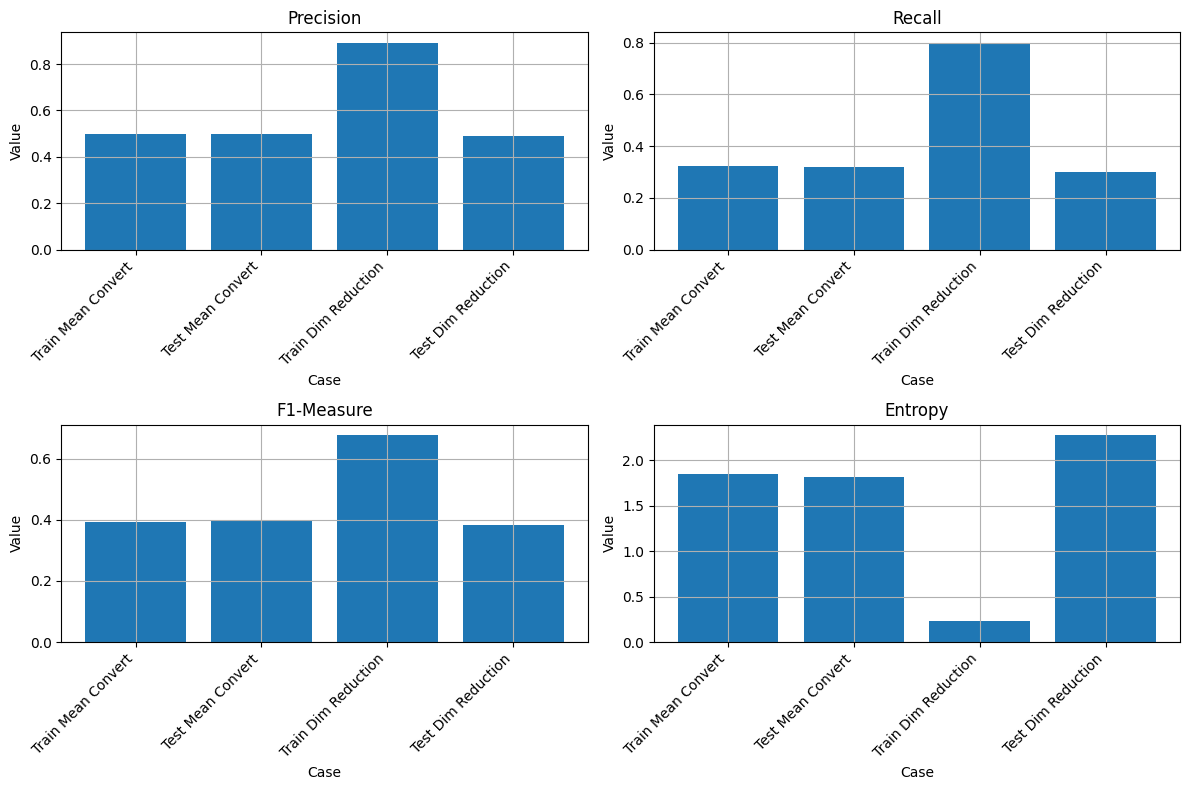

--------------------------K-Means evaluation using the mean of each column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.5353618421052632
The Recall is:  0.3021226982272915
The F1-Measure is:  0.3420660169935644
The Entropy is:  1.6012679497085343
The Jaccard Index is:  0.18431010061669423
The Rand Index is:  0.9298007001310679


------------Testing data evaluation----------
The Precision is:  0.5350877192982456
The Recall is:  0.2975184672206833
The F1-Measure is:  0.3416316488114007
The Entropy is:  1.5656832881691547
The Jaccard Index is:  0.18007237264928605
The Rand Index is:  0.9294041294954336


--------------------------K-Means evaluation using the dim-reduction column approach-------------------------------


------------Training data evaluation----------
The Precision is:  0.9470942982456142
The Recall is:  0.7268233818881407
The F1-Measure is:  0.5659310579596513
The Entropy is:  0.11053032003984051
The Jaccard 

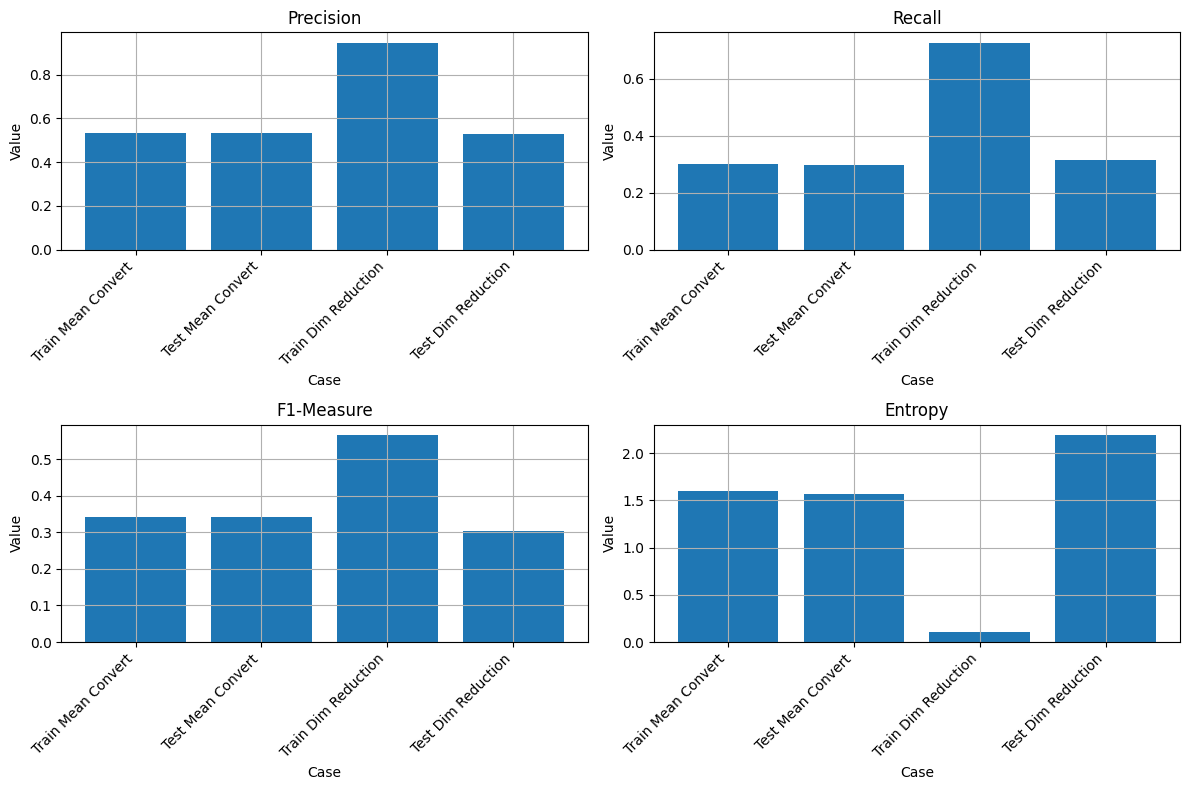

In [ ]:
ks = [8, 13, 19, 28, 38]

for k in ks:
    results, clusters_test_mean, clusters_test_dim = evaluate_kMeans(k)
    print("k = ", k)
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, index=["Precision", "Recall", "F1-Measure", "Entropy"])


    # Display the results in a tabulated format
    print("Results:")
    print(results_df)
    print("-----------------------------------------------------------------")

    # Display the clusters for the test mean convert solution
    print("Clusters for Test Mean Convert:")
    print("Cluster\tNumber of Points")
    for i, cluster in enumerate(clusters_test_mean):
        print(f"{i + 1}\t{len(cluster)}")

    print("-----------------------------------------------------------------")

    # Display the clusters for the test dim reduction solution
    print("Clusters for Test Dim Reduction:")
    print("Cluster\tNumber of Points")
    for i, cluster in enumerate(clusters_test_dim):
        print(f"{i + 1}\t{len(cluster)}")

    print("-----------------------------------------------------------------")

    # Plotting the results
    measures = ["Precision", "Recall", "F1-Measure", "Entropy"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, measure in enumerate(measures):
        ax = axes[i // 2, i % 2]
        bars = ax.bar(results.keys(), results_df.loc[measure])
        ax.set_title(measure)
        ax.set_ylabel("Value")
        ax.set_xlabel("Case")
        ax.grid(True)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# Function to plot the measures
def plot_measures(title, precisions, recalls, f1_measures, entropies, ks):
    plt.figure(figsize=(10, 6))

    plt.plot(ks, precisions, marker='o', label='Precision')
    plt.plot(ks, recalls, marker='o', label='Recall')
    plt.plot(ks, f1_measures, marker='o', label='F1-measure')
    plt.plot(ks, entropies, marker='o', label='Entropy')

    plt.title(title)
    plt.xlabel('k')
    plt.ylabel('Measure')
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)
    plt.show()

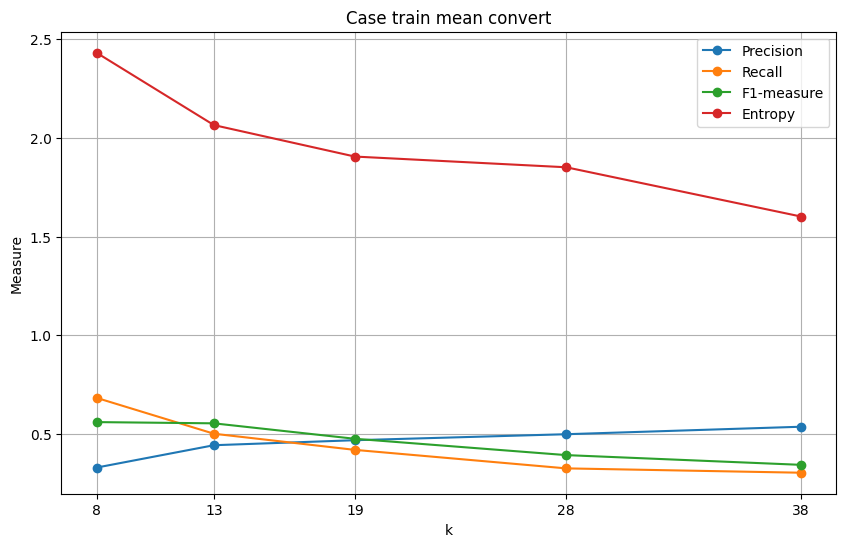

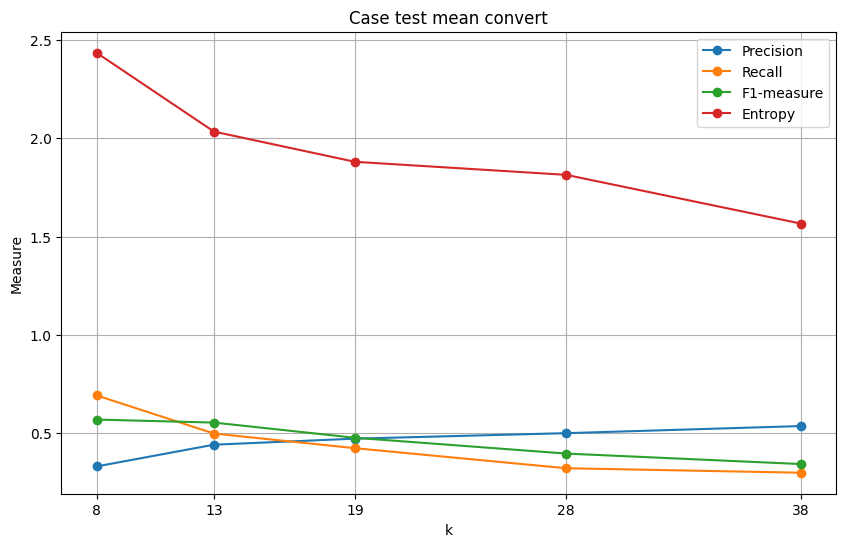

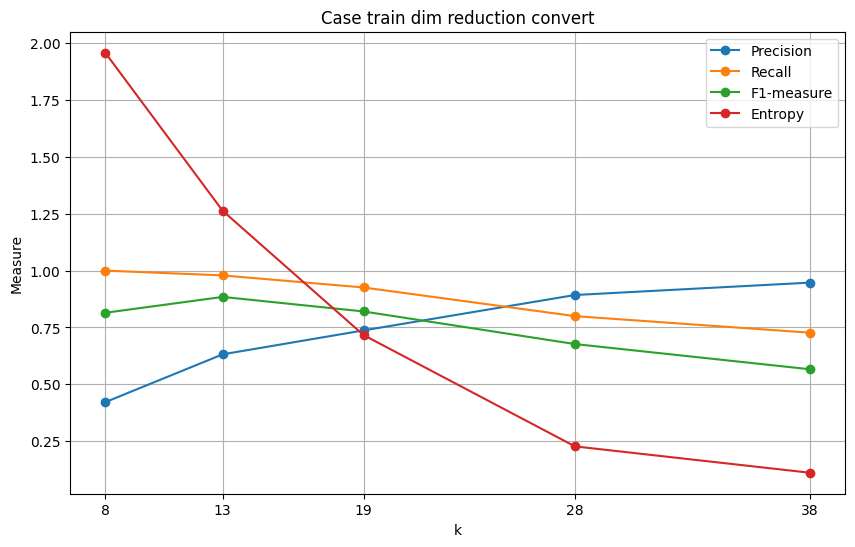

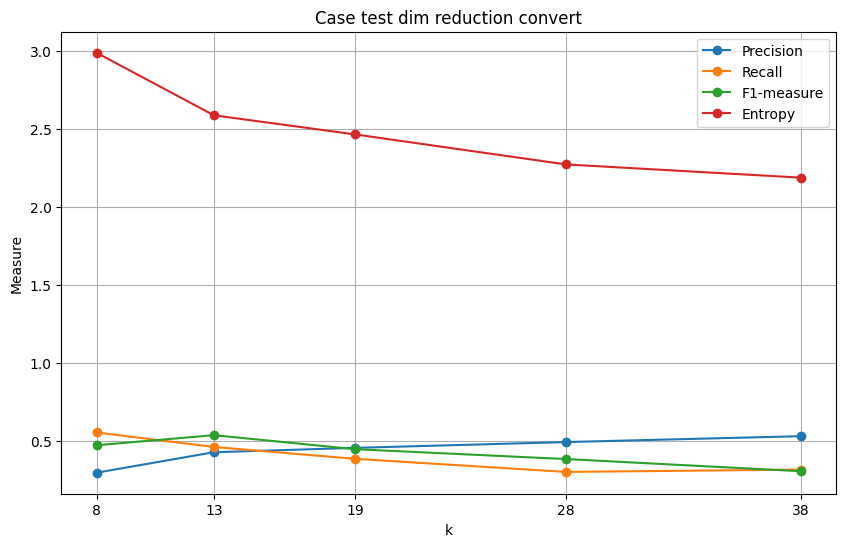

In [ ]:
# Compare the effect of k
# Case train mean convert
precisions_case1 = []
recall_case1 = []
F1_measure_case1 = []
entropy_case1 = []

# Case test mean convert
precisions_case2 = []
recall_case2 = []
F1_measure_case2 = []
entropy_case2 = []

# Case train dim reduction convert
precisions_case3 = []
recall_case3 = []
F1_measure_case3 = []
entropy_case3 = []

# Case test dim reduction convert
precisions_case4 = []
recall_case4 = []
F1_measure_case4 = []
entropy_case4 = []

# Parse and map the evaluation results for each k value
results_per_k = {
    8: [
        [0.328125, 0.6818887132976044, 0.5588471683540754, 2.432008666835668],
        [0.3294956140350877, 0.6912280701754386, 0.568146678747352, 2.4357135186366023],
        [0.42105263157894735, 1.0, 0.8143939393939393, 1.9589095236249274],
        [0.2949561403508772, 0.553393351800554, 0.4714594758673014, 2.9910652152141326]
    ],
    13: [
        [0.4416118421052631, 0.4998081856076222, 0.5525858534015574, 2.065000970336526],
        [0.44024122807017546, 0.4970567867036011, 0.5527910311875451, 2.0342500100299468],
        [0.631578947368421, 0.9789090055425771, 0.8842118798096356, 1.263157894736842],
        [0.42653508771929827, 0.4602723915050785, 0.5360347553866366, 2.589389960460817]
    ],
    19: [
        [0.46696820175438586, 0.4179814541248683, 0.47423713563184344, 1.9054441915891795],
        [0.4709429824561403, 0.42240304709141274, 0.47552839602181385, 1.880447979701567],
        [0.7368421052631577, 0.9257499370161697, 0.8202505475781385, 0.7162968670756216],
        [0.4544956140350877, 0.38426823638042473, 0.44610233071238964, 2.4668564319648736]
    ],
    28: [
        [0.49739583333333337, 0.32416346021712245, 0.3914672736749137, 1.8511333070570763],
        [0.4989035087719298, 0.3203947368421053, 0.3949997957949412, 1.8139632016542813],
        [0.8926809210526315, 0.7996870848793001, 0.6767599430549865, 0.2264206050658975],
        [0.4917763157894736, 0.30003462603878117, 0.3826298385740328, 2.273882946991791]
    ],
    38: [
        [0.5353618421052632, 0.3021226982272915, 0.3420660169935644, 1.6012679497085343],
        [0.5350877192982456, 0.2975184672206833, 0.3416316488114007, 1.5656832881691547],
        [0.9470942982456142, 0.7268233818881407, 0.5659310579596513, 0.11053032003984051],
        [0.5296052631578949, 0.31513157894736843, 0.3046155739378422, 2.1890959810089488]
    ]
}

# Map the evaluation results to the corresponding arrays
for k, results in results_per_k.items():
    precisions_case1.append(results[0][0])
    recall_case1.append(results[0][1])
    F1_measure_case1.append(results[0][2])
    entropy_case1.append(results[0][3])

    precisions_case2.append(results[1][0])
    recall_case2.append(results[1][1])
    F1_measure_case2.append(results[1][2])
    entropy_case2.append(results[1][3])

    precisions_case3.append(results[2][0])
    recall_case3.append(results[2][1])
    F1_measure_case3.append(results[2][2])
    entropy_case3.append(results[2][3])

    precisions_case4.append(results[3][0])
    recall_case4.append(results[3][1])
    F1_measure_case4.append(results[3][2])
    entropy_case4.append(results[3][3])

# Plot for Case train mean convert
plot_measures("Case train mean convert", precisions_case1, recall_case1, F1_measure_case1, entropy_case1, [8, 13, 19, 28, 38])

# Plot for Case test mean convert
plot_measures("Case test mean convert", precisions_case2, recall_case2, F1_measure_case2, entropy_case2, [8, 13, 19, 28, 38])

# Plot for Case train dim reduction convert
plot_measures("Case train dim reduction convert", precisions_case3, recall_case3, F1_measure_case3, entropy_case3, [8, 13, 19, 28, 38])

# Plot for Case test dim reduction convert
plot_measures("Case test dim reduction convert", precisions_case4, recall_case4, F1_measure_case4, entropy_case4, [8, 13, 19, 28, 38])


## **Comparison between the 3 clustering algorithms**

In [ ]:
from tabulate import tabulate

# Mean Convert Case
mean_convert_table_data = [
    ["Precision", 0.4709, 0.5291, 0.5186403508771932],
    ["Recall", 0.4224, 0.4187, 0.41032552620718116],
    ["F1-Measure", 0.4755, 0.5215, 0.22913802388420818],
    ["Entropy", 1.8804, 1.7231, 1.524241224229374]
]

mean_convert_table_headers = ["Measure", "K-Means", "Spectral", "DBSCAN"]

mean_convert_table = tabulate(mean_convert_table_data, headers=mean_convert_table_headers, tablefmt="pipe")

print("Mean Convert Case:")
print(mean_convert_table)

# Dim Reduction Convert Case
dim_reduction_convert_table_data = [
    ["Precision", 0.4545, 0.4583, 0.17708333333333334],
    ["Recall", 0.3843, 0.3281, 0.9877049180327869],
    ["F1-Measure", 0.4461, 0.4648, 0.6920025293059002],
    ["Entropy", 2.4669, 2.3826, 0.08331534115095454]
]

dim_reduction_convert_table_headers = ["Measure", "K-Means", "Spectral", "DBSCAN"]

dim_reduction_convert_table = tabulate(dim_reduction_convert_table_data, headers=dim_reduction_convert_table_headers, tablefmt="pipe")

print("\nDim Reduction Convert Case:")
print(dim_reduction_convert_table)

Mean Convert Case:
| Measure    |   K-Means |   Spectral |   DBSCAN |
|:-----------|----------:|-----------:|---------:|
| Precision  |    0.4709 |     0.5291 | 0.51864  |
| Recall     |    0.4224 |     0.4187 | 0.410326 |
| F1-Measure |    0.4755 |     0.5215 | 0.229138 |
| Entropy    |    1.8804 |     1.7231 | 1.52424  |

Dim Reduction Convert Case:
| Measure    |   K-Means |   Spectral |    DBSCAN |
|:-----------|----------:|-----------:|----------:|
| Precision  |    0.4545 |     0.4583 | 0.177083  |
| Recall     |    0.3843 |     0.3281 | 0.987705  |
| F1-Measure |    0.4461 |     0.4648 | 0.692003  |
| Entropy    |    2.4669 |     2.3826 | 0.0833153 |


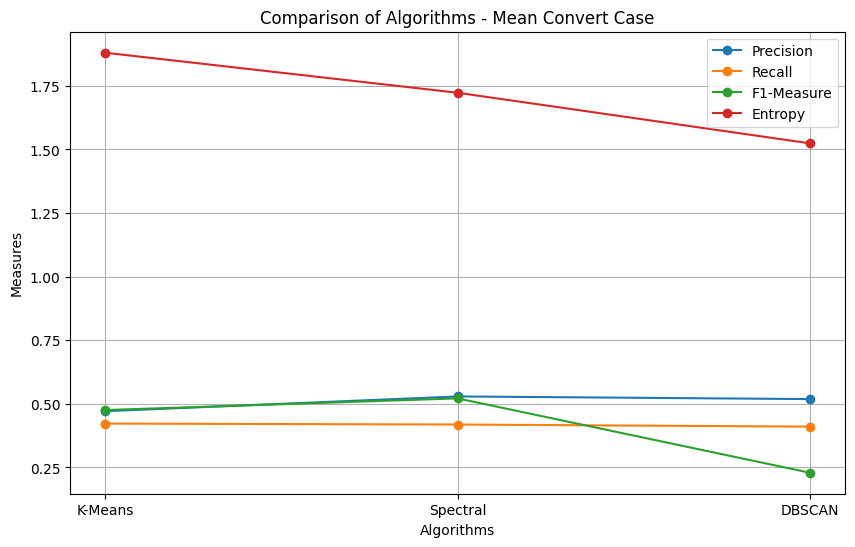

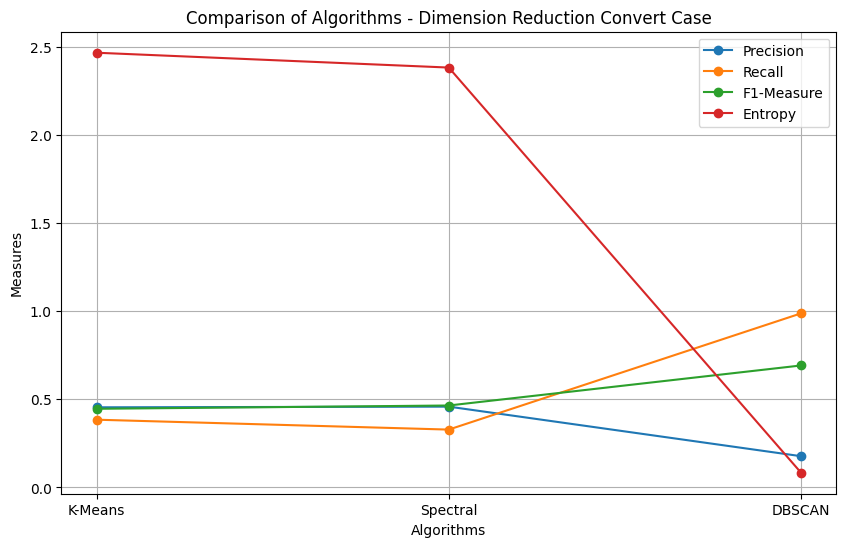

In [ ]:
# kmeans test results when k = 19
k_means_mean_convert_measures = [0.4709429824561403, 0.42240304709141274, 0.47552839602181385, 1.880447979701567]
k_means_dim_reduction_convert_measures = [0.4544956140350877, 0.38426823638042473, 0.44610233071238964, 2.4668564319648736]

# spectral testing results when k = 19
spectral_mean_convert_measures = [0.529057, 0.418652, 0.521502, 1.723093]
spectral_dim_reduction_convert_measures = [0.458333, 0.328093, 0.464799, 2.382628]

# dbscan testing results
dbscan_mean_convert_measures = [0.5186403508771932, 0.41032552620718116, 0.22913802388420818, 1.524241224229374]
dbscan_dim_reduction_convert_measures = [0.17708333333333334, 0.9877049180327869, 0.6920025293059002, 0.08331534115095454]

algorithms = ['K-Means', 'Spectral', 'DBSCAN']
measures = ['Precision', 'Recall', 'F1-Measure', 'Entropy']

plt.figure(figsize=(10, 6))

for i in range(len(measures)):
    plt.plot(algorithms, [k_means_mean_convert_measures[i], spectral_mean_convert_measures[i], dbscan_mean_convert_measures[i]], marker='o', label=measures[i])

plt.title('Comparison of Algorithms - Mean Convert Case')
plt.xlabel('Algorithms')
plt.ylabel('Measures')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for i in range(len(measures)):
    plt.plot(algorithms, [k_means_dim_reduction_convert_measures[i], spectral_dim_reduction_convert_measures[i], dbscan_dim_reduction_convert_measures[i]], marker='o', label=measures[i])

plt.title('Comparison of Algorithms - Dimension Reduction Convert Case')
plt.xlabel('Algorithms')
plt.ylabel('Measures')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tabulate import tabulate

# K-Means with k = 19, Mean Convert
k_means_mean_convert_clusters = [
    [65, 14, 96, 129, 58, 79, 247, 167, 63, 174, 86, 24, 5, 110, 96, 208, 51, 88, 64],
    [46, 77, 84, 69, 109, 128, 44, 125, 62, 48, 64, 56, 56, 75, 94, 356, 111, 77, 143]
]

# Spectral with k = 19, Mean Convert
spectral_mean_convert_clusters = [
    [16, 136, 158, 121, 109, 74, 106, 93, 95, 101, 99, 85, 84, 131, 61, 86, 73, 108, 88],
    [103, 91, 117, 109, 118, 47, 80, 108, 106, 87, 102, 155, 47, 98, 51, 126, 99, 97, 83]
]

# Merge K-Means and Spectral clusters
merged_clusters = []
for k_means_cluster, spectral_cluster in zip(k_means_mean_convert_clusters, spectral_mean_convert_clusters):
    merged_cluster = []
    for k_means_count, spectral_count in zip(k_means_cluster, spectral_cluster):
        merged_cluster.append((k_means_count, spectral_count))
    merged_clusters.append(merged_cluster)

# Display merged clusters in a table
table_headers = ["Cluster", "K-Means (Mean Convert) # points", "Spectral (Mean Convert) # points", "K-Means (Dim Reduction) # points", "Spectral (Dim Reduction) # points"]
table_data = []

for i in range(len(k_means_mean_convert_clusters[0])):
    table_row = [i+1]
    for j in range(len(merged_clusters)):
        table_row.extend(merged_clusters[j][i])
    table_data.append(table_row)

print(tabulate(table_data, headers=table_headers, tablefmt="pipe"))


|   Cluster |   K-Means (Mean Convert) # points |   Spectral (Mean Convert) # points |   K-Means (Dim Reduction) # points |   Spectral (Dim Reduction) # points |
|----------:|----------------------------------:|-----------------------------------:|-----------------------------------:|------------------------------------:|
|         1 |                                65 |                                 16 |                                 46 |                                 103 |
|         2 |                                14 |                                136 |                                 77 |                                  91 |
|         3 |                                96 |                                158 |                                 84 |                                 117 |
|         4 |                               129 |                                121 |                                 69 |                                 109 |
|         5 |               

## **<font color='#0e77c2' size='6px'>New Clustering Algorithm (Your implementation)</font>**

Your goal is to get to know to other clustering techniques and how they are
working and differ than K-Means and Normalized cut. Choose any clustering
technique of your own choice, implement it and repeat the above experiments.


<h2>DBSCAN (Density-Based Spatial Clustering of Applications with Noise) </h2>
<li> It is a density-based clustering algorithm that groups together closely packed points based on density. It defines clusters as continuous regions of high density separated by regions of low density.
<li> Can identify clusters of arbitrary shape and is robust to outliers. It can handle clusters with varying densities and does not assume a specific number of clusters in the data.
<li> Does not require specifying the number of clusters beforehand. It automatically detects the number of clusters based on the density of data points.
<li> Can identify outliers as noise points since they do not belong to any cluster. It forms clusters by connecting high-density points and ignores sparse regions.
<li> Has a time complexity of O(n log n) for efficient implementations. However, it may consume more memory due to maintaining neighborhood information for each point.
<li> Less sensitive to initialization since it does not involve centroid initialization. Parameters like epsilon (eps) and minimum samples (min_samples) influence clustering but are generally more intuitive to set.

---
<h3> DBSCAN Explained <h3>

The representative-based clustering methods like K-means and expectationmaximization
are suitable for finding ellipsoid-shaped clusters, or at best convex
clusters. However, for nonconvex clusters,these
methods have trouble finding the true clusters, as two points from different clusters
may be closer than two points in the same cluster. The density-based methods are able to mine such nonconvex clusters.
Density-based clustering uses the local density of points to determine the clusters,
rather than using only the distance between points.We define a ball of radius ǫ around
a point x ∈ Rd , called the ǫ-neighborhood of x, as follows:
Nǫ(x) = Bd (x,ǫ) = {y | δ(x,y) ≤ ǫ}


In [ ]:
import numpy as np
from collections import deque

def _DBSCAN(X, epsilon=0.5, min_samples=5):
    """
    DBSCAN clustering algorithm implementation.

    Parameters:
    - X: Input data matrix of shape (n_samples, n_features).
    - epsilon: Maximum distance to consider neighbors (default=0.5).
    - min_samples: Minimum number of neighbors to form a cluster (default=5).

    Returns:
    - cluster_labels: Cluster labels for each data point.
    """
    k = 0
    n_samples = X.shape[0]
    cluster_label = -1  # Label for noise points and unassigned points
    labels = np.full(n_samples, -1)  # Initialize with unassigned label (-1)

    for i in range(n_samples):
        if labels[i] != -1:  # Skip points already assigned to a cluster
            continue

        neighbors = _find_neighbors(X, i, epsilon)
        if len(neighbors) < min_samples:  # Noise point (not enough neighbors)
            labels[i] = cluster_label
            continue

        k += 1  # Start a new cluster
        labels[i] = k
        queue = deque(neighbors)

        while queue:
            neighbor_index = queue.popleft()
            if labels[neighbor_index] == -1:  # Neighbor not assigned to any cluster
                labels[neighbor_index] = k
                new_neighbors = _find_neighbors(X, neighbor_index, epsilon)
                if len(new_neighbors) >= min_samples:  # Core point
                    queue.extend(new_neighbors)

    return labels

def _find_neighbors(X, index, epsilon):
    """
    Find neighbors within epsilon distance for a given data point.

    Parameters:
    - X: Input data matrix of shape (n_samples, n_features).
    - index: Index of the data point for which neighbors are to be found.
    - epsilon: Maximum distance to consider neighbors.

    Returns:
    - neighbors: Indices of neighbors within epsilon distance.
    """
    distances = np.linalg.norm(X - X[index], axis=1)  # Euclidean distances
    return np.where(distances <= epsilon)[0]  # Indices of neighbors within epsilon distance

Grid Search

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
def grid_search_dbscan(data, eps_values, min_samples_values):
    best_score = -1
    best_params = {}

    for params in ParameterGrid({'epsilon': eps_values, 'min_samples': min_samples_values}):
        dbscan = DBSCAN(**params)
        clusters = dbscan.fit_predict(data)

        # Exclude noise points (-1) from silhouette score calculation
        if len(np.unique(clusters)) > 1:
            silhouette_avg = silhouette_score(data, clusters)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = params

    return best_params, best_score

<h2>Applying DBSCAN on Mean converted training data<h2>

In [ ]:
root_directory = "/content/data"
dataset_traing, dataset_testing, labels_training, labels_testing = read_dataset(root_directory)

In [ ]:
data_mean_convert = mean_convert(dataset_traing)

# Initialize DBSCAN clustering
dbscan1 = DBSCAN(epsilon=15,min_samples=18)

# Perform DBSCAN clustering on the scaled data
cluster_labels = dbscan1.fit_predict(data_mean_convert)

# Evaluate clustering performance using silhouette score
clusters = get_clusters(cluster_labels)
evaluate_cluster(clusters,labels_training)

The Precision is:  0.11184210526315788
 The Recall is:  0.9653703449223581
 The F1-Measure is:  0.3655555555555556
 The Entropy is:  3.907638960926699
 The Jaccard Index is:  0.05779942570819723
 The Rand Index is:  0.17379603910392843



<h1> Applying DBSCAN on LDA Projected training data

In [ ]:
data_lda_convert_training,data_lda_convert_testing = lda_convert(dataset_traing,dataset_testing,labels_training)

#Initialize DBSCAN
dbscan_lda = DBSCAN(epsilon=0.9,min_samples=1)

#Run DBSCAN on data
cluster_labels_lda = dbscan_lda.fit_predict(data_lda_convert_training)
#Evaluate Clustering
clusters = get_clusters(cluster_labels_lda)
evaluate_cluster(clusters,labels_training)

The Precision is:  0.10992324561403508
 The Recall is:  1.0
 The F1-Measure is:  0.6231582799869297
 The Entropy is:  0.0
 The Jaccard Index is:  1.0
 The Rand Index is:  1.0


<h2>Applying DBSCAN on Mean Converted testing data<h2>

Applying PCA then Plotting the data to understand it

In [ ]:
from sklearn.decomposition import PCA
data_mean_convert = mean_convert(dataset_testing)
print(len(dataset_testing))
pca = PCA(n_components=0.95)

reduced_data = pca.fit_transform(data_mean_convert)
print(pca.explained_variance_ratio_)
# Plot the reduced data points in 2D
plt.figure(figsize=(10, 20))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', label='Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: 2D Plot of Multidimensional Data')
plt.legend()
plt.grid(True)
plt.savefig("PCA Reduced.jpeg")
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
pca = PCA(n_components=4)
reduced_data = pca.fit_transform(data_mean_convert)

# Initialize DBSCAN clustering
clustering = DBSCAN(eps=4, min_samples=8).fit(data_mean_convert)
labels = _DBSCAN(data_mean_convert,epsilon=4,min_samples=6)

# Perform DBSCAN clustering on the scaled data
# cluster_labels = dbscan1.fit_predict(data_mean_convert)

# Evaluate clustering performance using silhouette score
count = 0
for i in range(len(labels)):
  if (labels[i] == -1):
    count+=1

print("noise = ", count)

clusters = get_clusters(labels)

evaluate_cluster(clusters, labels_testing)
evaluate_cluster(get_clusters(clustering.labels_),labels_testing)

noise = 110

our algorithm measures

 The Precision is:  0.5186403508771932
 The Recall is:  0.41032552620718116
 The F1-Measure is:  0.22913802388420818
 The Entropy is:  1.524241224229374
 The Jaccard Index is:  0.10797703006319448
 The Rand Index is:  0.8190691558933267


 builtin algorithm measures

 The Precision is:  0.5186403508771932
 The Recall is:  0.41032552620718116
 The F1-Measure is:  0.22913802388420818
 The Entropy is:  1.524241224229374
 The Jaccard Index is:  0.10797703006319448
 The Rand Index is:  0.8190691558933267


<h2>Applying DBSCAN on LDA Projected testing data</h2>

In [ ]:
#Project Data using LDA
data_lda_convert_training,data_lda_convert_testing = lda_convert(dataset_traing,dataset_testing,labels_training)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_lda_convert_testing[:, 0], data_lda_convert_testing[:, 1],data_lda_convert_testing[:, 2],c='blue', label='Data Points')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot')
plt.savefig("LDA Reduced.jpeg")
plt.show()

In [ ]:
#Initialize DBSCAN

#Apply DBSCAN on projected data
cluster_labels_lda = _DBSCAN(data_lda_convert_testing,epsilon=10,min_samples=2)

#Evaluate Clustering
clusters = get_clusters(cluster_labels_lda)
evaluate_cluster(clusters, labels_testing)

 The Precision is:  0.17708333333333334
 The Recall is:  0.9877049180327869
 The F1-Measure is:  0.6920025293059002
 The Entropy is:  0.08331534115095454
 The Jaccard Index is:  0.7470551766893986
 The Rand Index is:  0.9341094139021601


Grid Search

In [ ]:
from sklearn.metrics import f1_score
from itertools import product

# Define parameter grid
eps_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
min_samples_values = range(2,5,1)

best_score = -1  # Initialize best score
best_params = {}  # Initialize best parameters

for eps, min_samples in product(eps_values, min_samples_values):
    # Create DBSCAN instance

    # Fit DBSCAN clustering
    clusters = DBSCAN(data_mean_convert,epsilon=eps,min_samples = min_samples)

    # Evaluate clustering using F1-score (or any other metric)
    score = f1_score(labels_testing, labels)  # Assuming true labels are available

    # Update best score and parameters if current score is better
    if score > best_score:
        best_score = score
        best_params['eps'] = eps
        best_params['min_samples'] = min_samples

print("Best F1-score:", best_score)
print("Best Parameters:", best_params)

Best F1-score: 0.046052631578947366
Best Parameters:  {'eps': 0.1, 'min_samples': 2}
